# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis.app", no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

#### Algorithms to use: DDPG vs MADDPG

We have just implemented Deep Deterministic Policy Gradients (DDPG), a actor-critic algorithm or a DQN method for continuous control project. Please see below, the breif explanation about DDPG: 

The actor approximates the optimal policy deterministically and output the best believed action for any given state. The critic learns the optimal value function by using the actors best believed action. There are two main features of DDPG:

- experience reply buffer which refers to learn from the previous experience (memory), as in DQN. We set a Reply buffer with fixed size (BUFFER_SIZE) and stored the experiences in the buffer. When updating the parameters, we sample a few (batch_size) memory from the buffer. In this way, we can break the sequential nature of experiences and stabilize the learning algorithm.
- soft updates to the target networks
    
    Note: there are 4 neural networks:
        - two regular networks (like the local/evaluate network in DQN whose parameters update all the time): one for the actor and one for the critic
        - two target networks (like the target network in DQN whose parameters update after a certain steps): one for the actor and one for the critic
    The target networks update using a soft updates strategy, e.g, when updating the target network $\theta_{target}$, 
    $$\theta_{target} = \tau \cdot \theta_{local} + (1 - \tau)\cdot \theta_{target} $$
    Here, $\tau \leq 1$ and $\theta_{target}$ can be for either actor target network or critic target network. 
    
In 2018, OpenAIt proposed Multi-Agent Deep Deterministic Policy Gradients (MADDPG) to solve multi-agent RL problem (https://arxiv.org/abs/1706.02275). They tested MADDPG on a variety of tasks and it performed better than DDPG on all of them. Briefly, MADDPG is an extension of DDPG, taking inspiration from actor-critic reinforcement learning techniques. It uses decentralised actor, centralised critic approach. All agents have access to all other agent’s state observation and actions during critic training but tries to predict its own action with only its own state observation during execution. 

![title](MADDPG.png)

As shown in the picture taken from OpenAI paper (https://arxiv.org/abs/1706.02275), the input of the critic neural network is the concatenated states and action of all agents. The output is Q-Value for that state. This Q-value is used as baseline to train actor, which gets only specific agent's state as input and outputs this specific agent's action values.

#### Requirement

To view the architect of neural networks, please install python package `torchviz`. 
##### Mac Os
```shell
brew install graphviz 
conda install python-graphviz
pip install torchviz
```

###### Linux
- Ubuntu
```shell
apt-get install graphviz 
```
- RedHat or RedHat based
```shell
yum install graphviz 
```
then
```shell
conda install python-graphviz
pip install torchviz
```

###### Windows
Please go to https://graphviz.gitlab.io/_pages/Download/Download_windows.html and install `graphviz` according to the guidance. Then
```shell
conda install python-graphviz
pip install torchviz
```

#### Define run pipeline

In [5]:
# import
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchviz import make_dot

from model import Actor, Critic
from ddpg_agent import Agent as DDPG_Agent
from maddpg_agent import MADDPGAgentTrainer as MADDPG_Agent

import time
import pickle
import pandas as pd

`maddpg_agent` and `ddpg_agent` contains different agent classes. In both classes, the architects of the neural networks are same (from `model`). and look like below:
- The actor network
    
    It builds an actor (policy) network that maps states -> actions
    - The model has batch normalization and 3 fully connected layers
    - The first layer takes in the state passes it through 64 nodes with ReLu activation
    - The second layer take the output from first layer and passes through 64 nodes with ReLu activation
    - The third layer takes the output from the previous layer and outputs the action size with Tanh activation 
    - Adam optimizer.

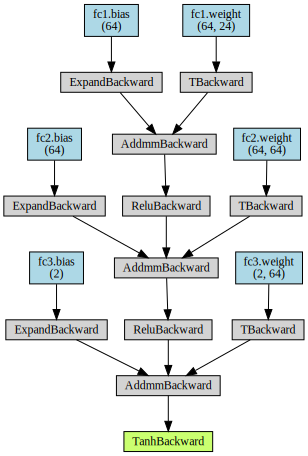

In [6]:
model = Actor(state_size, action_size)
model.eval()
x = Variable(torch.randn(1,state_size))
y = model(x)
             
make_dot(y, params=dict(list(model.named_parameters())))

- the critic network
  
  Build a critic (value) network that maps (state, action) pairs -> Q-values.
    - The model has batch normalization and 3 fully connected layers
    - The first layer takes the state and passes through 64 nodes with ReLu activation
    - Then we take the output from the first layer and concatenate it with the action size
    - We then pass this to second layer which forwards through 64 nodes with ReLu activation
    - The third layer takes the output from the previous layer and outputs the Q-value with ReLu activation
    - Adam optimizer

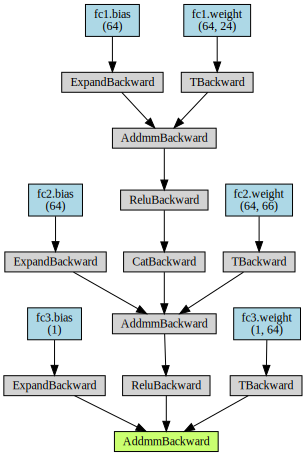

In [7]:
model = Critic(state_size, action_size, seed=0)
model.eval()
x = Variable(torch.randn(1,state_size))
z = Variable(torch.randn(1,action_size))
y = model(x, z)
             
make_dot(y, params=dict(list(model.named_parameters())))

Note: both actor and critic network have one argument `use_bn` which can control whether the input for each layer needs to be batch normalized. 

In [9]:
def train_agent(env = None, agent = None, num_agents = 1, n_episodes=2000,
                max_steps=1000, window_size=100,score_threshold=1.0, print_every=50, agent_type=None):
    """
    Params
    ======
        env: environment
        agent: agent class
        num_agents (int): number of agents. Default is 1
        n_episodes (int): maximum number of training episodes
        max_steps (int): maximum time steps allowed within one training episode
        window_size (int): window size used to get last window_size scores
        score_threshold (float): minimum value to reach (required by the project assinment)
        print_every (float): print out every print_every episodes
        agent_type (str): 'ddpg' or 'maddpg'
    """

    scores_deque = deque(maxlen=window_size) # last window_size scores
    scores = []        
    
    n_episode_reach_requirement = None # in how many episode, the problem is solved
    
    for i_episode in range(1, n_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
            
        episode_scores = np.zeros(num_agents) 

        for t in range(max_steps):
            actions = agent.act(states)
            
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones)
            
            episode_scores += np.array(rewards)
            states = next_states
            if np.any(dones):
                break
        
        episode_score = np.max(episode_scores)
        scores_deque.append(episode_score)
        scores.append(episode_score)
        average_score = np.mean(scores_deque)

        print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, episode_score), end="")
        if i_episode % print_every == 0:
            print('\rEpisode: {}\tAverage Score: {:.2f}\tCurrent Score: {:.2f}'.format(i_episode, average_score, episode_score))

        if average_score >= score_threshold:
            if n_episode_reach_requirement is None:
                n_episode_reach_requirement = i_episode - window_size
                print('\nEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(i_episode-window_size, average_score))
            if agent_type == 'maddpg':
                for i, a in enumerate(agent):
                    torch.save(a.actor_local.state_dict(), ''.join('agent_' + str(i) + 'checkpoint_actor.pth'))
                    torch.save(a.critic_local.state_dict(), ''.join('agent_' + str(i) + 'checkpoint_critic.pth'))
            else:
                torch.save(agent.actor_local.state_dict(), ''.join('checkpoint_actor.pth'))
                torch.save(agent.critic_local.state_dict(), ''.join('checkpoint_critic.pth'))

    return scores, n_episode_reach_requirement


The other hyper-parameters which are not seen in notebook but in .py files are

- BUFFER_SIZE: int(1e6)  # replay buffer size
- BATCH_SIZE: 512        # minibatch size
- GAMMA: 0.95            # discount factor
- TAU: 1e-2              # for soft update of target parameters
- LR_ACTOR = 1e-3        # learning rate of the actor 
- LR_CRITIC = 1e-3       # learning rate of the critic
- UPDATE_EVERY = 1       # how often to update the network
- WEIGHT_DECAY = 0       # L2 weight decay

#### Training

In [10]:
def select_agent(agent):
    if agent == 'ddpg':
        return DDPG_Agent(state_size=state_size, action_size=action_size, n_agents=num_agents, random_seed=48)
    elif agent == 'maddpg':
        return MADDPG_Agent(state_size=state_size, action_size=action_size, n_agents=num_agents, random_seed=48)
    else:
        print("wrong selection. select from 1. ddpg, 2. maddpg")

In [11]:
agent_types = ['maddpg', 'ddpg']
all_scores = dict()
all_n_episode_reach_requirement = dict()
for agent_type in agent_types:
    print(agent_type, "training starts:", time.ctime())
    agent = select_agent(agent_type)
    scores, n_episode_reach_requirement = train_agent(env=env, agent=agent, 
                                                      num_agents=num_agents,
                                                      n_episodes=3000,
                                                      max_steps=5000,
                                                      window_size=100, 
                                                      score_threshold=0.5, 
                                                      print_every=100, 
                                                      agent_type=agent_type)
    print("Finish training:", time.ctime(), '\n\n\n')
    all_scores[agent_type] = scores
    all_n_episode_reach_requirement[agent_type] = n_episode_reach_requirement

# save the scores and the number of episodes required to solve the problem
with open('training_scores.pickle', 'wb') as handle:
    pickle.dump(all_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('training_solved_in_n_episodes.pickle', 'wb') as handle:
    pickle.dump(all_n_episode_reach_requirement, handle, protocol=pickle.HIGHEST_PROTOCOL)    

maddpg training starts: Thu Oct 24 12:04:50 2019
Episode: 100	Average Score: 0.01	Current Score: 0.00
Episode: 200	Average Score: 0.00	Current Score: 0.00
Episode: 300	Average Score: 0.01	Current Score: 0.00
Episode: 400	Average Score: 0.06	Current Score: 0.00
Episode: 500	Average Score: 0.07	Current Score: 0.10
Episode: 600	Average Score: 0.07	Current Score: 0.10
Episode: 700	Average Score: 0.09	Current Score: 0.09
Episode: 800	Average Score: 0.10	Current Score: 0.10
Episode: 900	Average Score: 0.14	Current Score: 0.10
Episode: 1000	Average Score: 0.18	Current Score: 0.10
Episode: 1100	Average Score: 0.18	Current Score: 0.50
Episode: 1200	Average Score: 0.21	Current Score: 0.60
Episode: 1300	Average Score: 0.25	Current Score: 0.00
Episode: 1400	Average Score: 0.40	Current Score: 1.00
Episode: 1500	Average Score: 0.32	Current Score: 0.20
Episode: 1600	Average Score: 0.46	Current Score: 0.10
Episode: 1700	Average Score: 0.33	Current Score: 0.10
Episode: 1800	Average Score: 0.36	Current 

#### Plots

maddpg solved the problem in None episodes


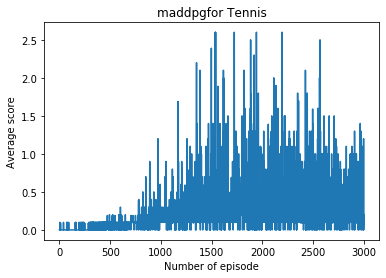

ddpg solved the problem in 673 episodes


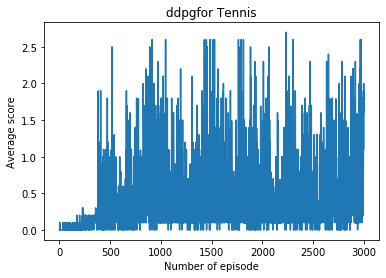

In [12]:
for method, scores in all_scores.items():
    # plot the scores
    print(method, "solved the problem in", all_n_episode_reach_requirement[method], 'episodes')
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Average score')
    plt.xlabel('Number of episode')
    plt.title("".join(method + 'for Tennis'))
    plt.savefig("".join(method+"traning_plot.pdf"))
    plt.show()

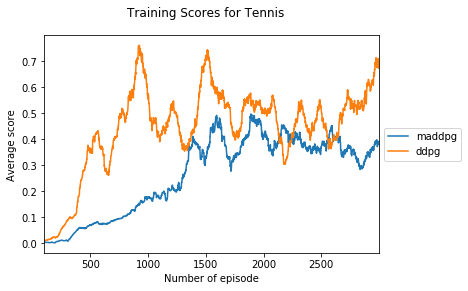

In [13]:
score_df = pd.DataFrame(all_scores)
fig, ax = plt.subplots()
score_df.rolling(100).mean().dropna().plot(ax=ax)
ax.set_xlabel("Number of episode")
ax.set_ylabel("Average score")
fig.suptitle("Training Scores for Tennis")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("multiple_training_plot.pdf")
plt.show()

When finished, you can close the environment.

In [14]:
env.close()

#### Lessons learned and future work
I was expected MADDPG performs better than DDPG. But the results shown above didn't look like so. It can be the problem that the hyperparameters for MADDPG were not suitable. During the trying for DDPG, the performance was affected by the hypterparameters a lot. Actually, the above was the only one trial for MADDPG which learns relatively fast and is close to success and the shown case for DDPG was adjusted for many times then got the above nice result. Initially, I didn't expected that DDPG learn so fast after many failure. 

Changing the hyperparameters could potentially speed up training or increase the final score. It can be improved in the future if I try more combinations with the different settings of hyperparameters. The other thing affecting the performance was the architecture of the neural network. Future improvement can be to modify the neural network architecture by changing the number of layers or neurons. 

In the Continuous Control project, I used leakyReLu instead ReLu in the neural network. But it didn't perform so well on this project in the initial try. I plan to reshape the architect with leakyReLu (see `model_leakyReLu.py`) and play with the hypterparameters to see whether the problem can be solved quickly.  

There are also other RL algorithms, such as PPO (https://arxiv.org/pdf/1707.06347.pdf) or D4PG (https://openreview.net/pdf?id=SyZipzbCb), which can be play around to see the performance in this project. 